In [1]:
import matplotlib.pyplot as plt
import metadata
import midi
import numpy as np
import pandas as pd
import pathlib
import similarity
import util

{'dataset_root': '../../sabana/dataset/asap-dataset', 'frame_per_second': 20, 'slice_duration': 5.0, 'expansion_rate': 1.5, 'settling_frame': 10, 'compensation_frame': 0, 'use_subsequence_dtw': True, 'use_decay_for_histogram': True}
# of pos_*.npz files: 100
# of neg_*.npz files: 92


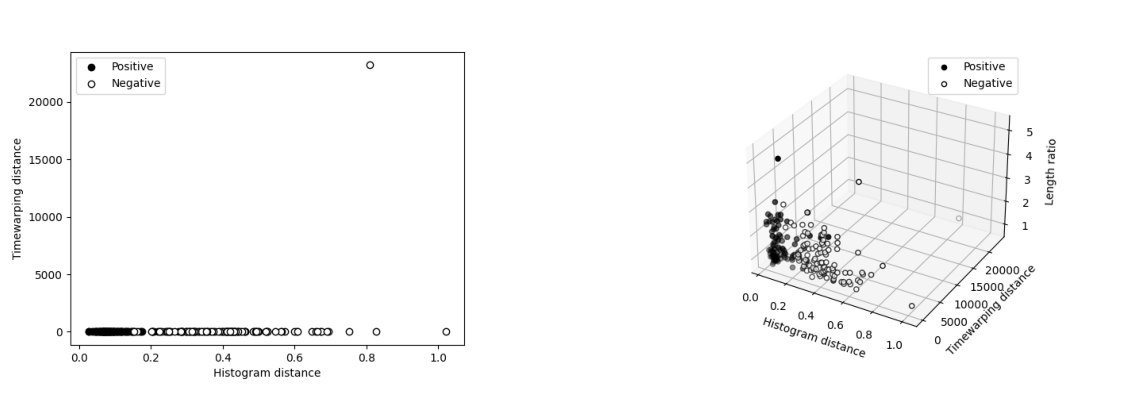

<Figure size 432x288 with 0 Axes>

In [2]:
save_root = "./save_asap"
save_root = pathlib.Path(save_root)
if not save_root.exists():
    raise FileExistsError(save_root)
elif not save_root.is_dir():
    raise FileExistsError(save_root)

config_path = save_root / "config.json"
if not config_path.exists():
    raise FileExistsError(config_path)
elif not config_path.is_file():
    raise FileExistsError(config_path)
config = metadata.Metadata.load(filepath=config_path)
print(config.get_config())

scatter_2d_path = save_root / "scatter_2d.png"
if not scatter_2d_path.exists():
    raise FileExistsError(scatter_2d_path)
elif not scatter_2d_path.is_file():
    raise FileExistsError(scatter_2d_path)

scatter_3d_path = save_root / "scatter_3d.png"
if not scatter_3d_path.exists():
    raise FileExistsError(scatter_3d_path)
elif not scatter_3d_path.is_file():
    raise FileExistsError(scatter_3d_path)

pos_csv_path = save_root / "pos.csv"
if not pos_csv_path.exists():
    raise FileExistsError(pos_csv_path)
elif not pos_csv_path.is_file():
    raise FileExistsError(pos_csv_path)
pos_csv = pd.read_csv(pos_csv_path)

neg_csv_path = save_root / "neg.csv"
if not neg_csv_path.exists():
    raise FileExistsError(neg_csv_path)
elif not neg_csv_path.is_file():
    raise FileExistsError(neg_csv_path)
neg_csv = pd.read_csv(neg_csv_path)

npz_root = save_root / "npz"
if not npz_root.exists():
    raise FileExistsError(npz_root)
elif not npz_root.is_dir():
    raise FileExistsError(npz_root)
pos_npz_paths = list(npz_root.glob("*pos*"))
neg_npz_paths = list(npz_root.glob("*neg*"))

num_pos_npz = len(pos_npz_paths)
num_neg_npz = len(neg_npz_paths)

print(f"# of pos_*.npz files: {num_pos_npz}")
print(f"# of neg_*.npz files: {num_neg_npz}")

fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].axis("off")
ax[0].imshow(plt.imread(scatter_2d_path))
ax[1].axis("off")
ax[1].imshow(plt.imread(scatter_3d_path))
plt.show()
plt.clf()

In [3]:
histogram_min, histogram_max = (0, 1.0)
timewarping_min, timewarping_max = (20000, 20000000)

In [4]:
selected_pos_indices = pos_csv.index[pos_csv["Histogram distance"] <= histogram_max].tolist()
print(len(selected_pos_indices))

100


In [5]:
selected_neg_indices = neg_csv.index[neg_csv["Timewarping distance"] >= timewarping_min].tolist()
print(len(selected_neg_indices))
print(selected_neg_indices)

1
[74]


['score', 'perf', 'alignment']


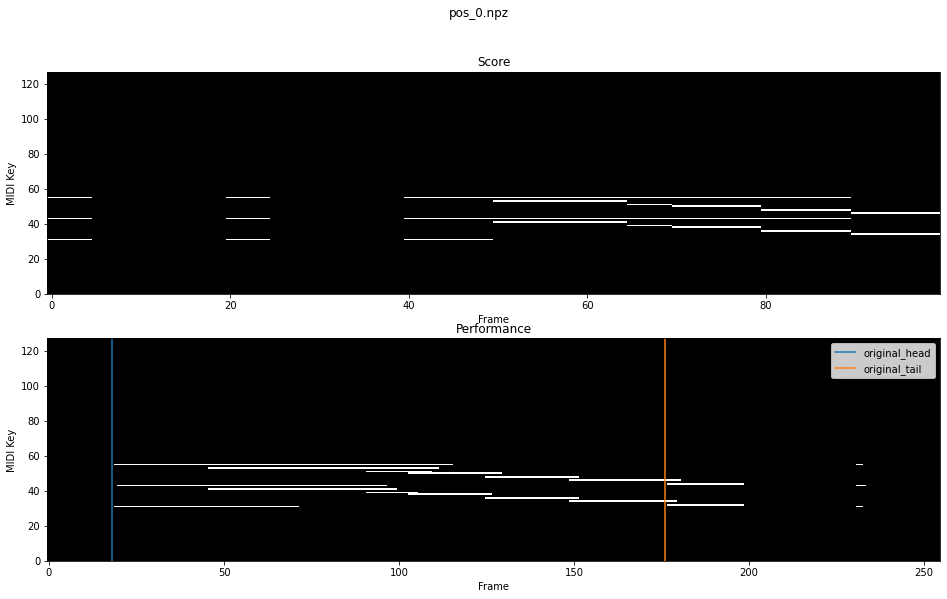

<Figure size 432x288 with 0 Axes>

In [6]:
for selected_pos_index in selected_pos_indices[:1]:
    selected_pos_npz_path = pos_npz_paths[selected_pos_index]
    with np.load(selected_pos_npz_path, allow_pickle=True) as selected_pos_npz_file:
        print(selected_pos_npz_file.files)
        score = selected_pos_npz_file["score"]
        perf = selected_pos_npz_file["perf"]
        head, tail = selected_pos_npz_file["alignment"]
        util.plot_midi_matrices(score, perf, (head, tail), title=f"pos_{selected_pos_index}.npz")

['score', 'perf']


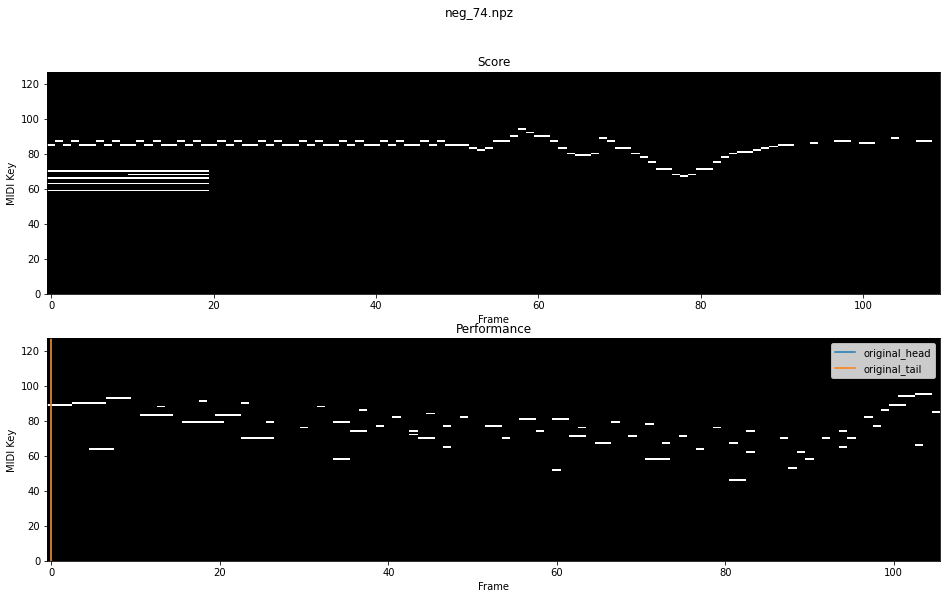

<Figure size 432x288 with 0 Axes>

In [7]:
for selected_neg_index in selected_neg_indices[:1]:
    selected_neg_npz_path = neg_npz_paths[selected_neg_index]
    with np.load(selected_neg_npz_path, allow_pickle=True) as selected_neg_npz_file:
        print(selected_neg_npz_file.files)
        score = selected_neg_npz_file["score"]
        perf = selected_neg_npz_file["perf"]
        util.plot_midi_matrices(score, perf, (0, 0), title=f"neg_{selected_neg_index}.npz")

In [8]:
score_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(score, settling_frame=10)
perf_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(perf, settling_frame=10)

score_sequence = score_unit_seq_list.to_representative_unit_sequence(config.compensation_frame)
perf_sequence = perf_unit_seq_list.to_representative_unit_sequence(config.compensation_frame)


if config.use_subsequence_dtw:
    timewarping_distance, (head, tail), (warping_path, accumulated_cost_matrix, delta_functions) = similarity.algorithm.subsequence_dtw(score_sequence, perf_sequence)

    if config.use_decay_for_histogram:
        score_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=True)
        perf_histogram = perf_unit_seq_list[head : tail + 1].to_pitch_histogram(with_decay=True)
    else:
        score_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=False)
        perf_histogram = perf_unit_seq_list[head : tail + 1].to_pitch_histogram(with_decay=False)

else:
    timewarping_distance = similarity.algorithm.levenshtein(score_sequence, perf_sequence, stabilize=True)

    if config.use_decay_for_histogram:
        score_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=True)
        perf_histogram = perf_unit_seq_list.to_pitch_histogram(with_decay=True)
    else:
        score_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=False)
        perf_histogram = perf_unit_seq_list.to_pitch_histogram(with_decay=False)

histogram_distance = similarity.algorithm.euclidean(score_histogram, perf_histogram)

print(f"Histogram distance: {histogram_distance}, Timewarping distance: {timewarping_distance}")

Histogram distance: 0.8096408247947693, Timewarping distance: 7.341661937191061


In [9]:
print(f"Score histogram: {score_histogram}")
print(f"Perf histogram: {perf_histogram}")

Score histogram: [0.00816697 0.26588023 0.02359347 0.2831216  0.         0.01633394
 0.08076225 0.02359347 0.09800363 0.0154265  0.06533575 0.11978222]
Perf histogram: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
print(f"Score sequence: {score_sequence}")
print(f"Perf sequence: {perf_sequence[head: tail+1]}")

Score sequence: [Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(68, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(87, 9.0000), Note(85, 9.0000), Note(87, 9.0000), Note(85, 9.0000), Note(85, 8.0000), Note(85, 7.0000), Note(83, 9.0000), Note(82, 9.0000), Note(83, 9.

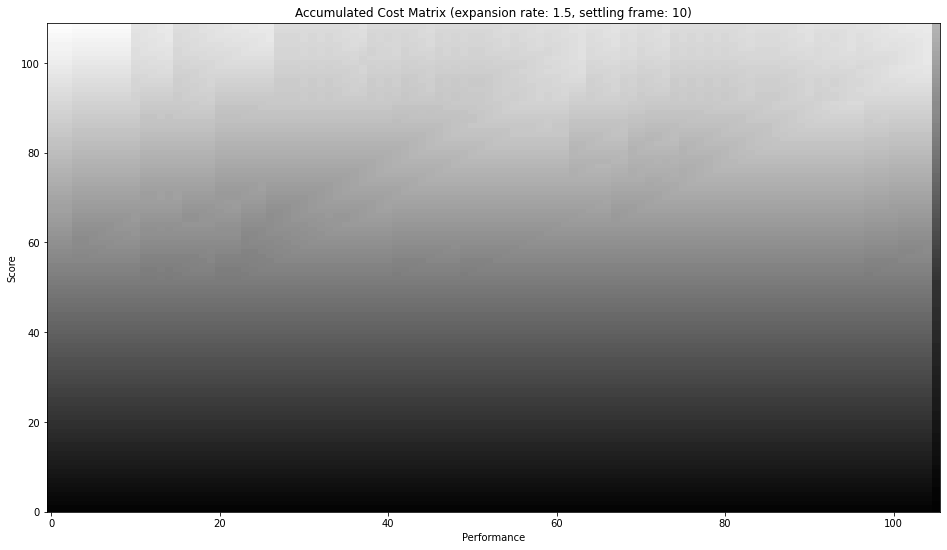

<Figure size 432x288 with 0 Axes>

In [11]:
ylim = [0, score.shape[-1] -1]
warping_path_ = np.array([(i, j) for (i, j) in warping_path])

plt.figure(figsize=(16, 9))
plt.title(f"Accumulated Cost Matrix (expansion rate: {config.expansion_rate}, settling frame: {config.settling_frame})")
plt.imshow(accumulated_cost_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
# plt.plot([original_head, original_head], ylim, "b", label="Original head")
# plt.plot([original_tail, original_tail], ylim, "y", label="Original tail")
# plt.plot([head, head], ylim, "g", label="Predicted head")
# plt.plot([tail, tail], ylim, "r", label="Predicted tail")
# plt.plot(warping_path_[:, 1], warping_path_[:, 0], 'w', label="Subsequence warping path")
plt.ylabel("Score")
plt.xlabel("Performance")
plt.ylim(ylim)
# plt.legend()
plt.show()
plt.clf()

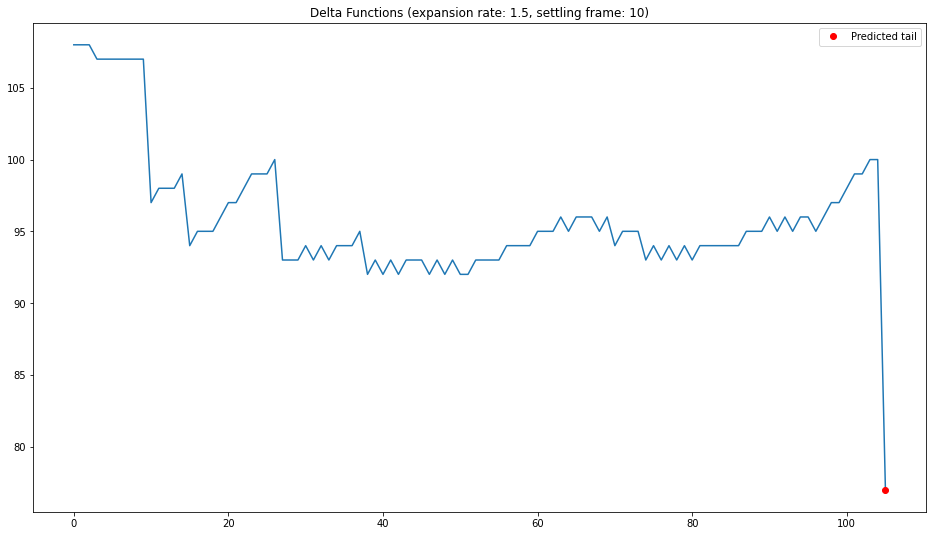

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(16, 9))
plt.title(f"Delta Functions (expansion rate: {config.expansion_rate}, settling frame: {config.settling_frame})")
plt.plot(np.arange(len(delta_functions)),delta_functions)
plt.plot(tail, delta_functions[tail], 'ro', label="Predicted tail")
plt.legend()
plt.show()
plt.clf()